In [3]:
import sqlalchemy as sq
import pymysql

import pandas as pd
import numpy as np

import os
import csv

import datetime as dt

sq.__version__

'1.0.13'

In [4]:

def convert_unixtime(stamp):
    return dt.datetime.fromtimestamp(
        int(stamp)
    ).strftime('%Y-%m-%d')

## Set up Dept List/Dict

In [5]:
dept_dict = {}

data_path = '/home/toferc/Documents/Data/'
output_path = '/home/toferc/Documents/Data/'

In [6]:
with open(os.path.join(data_path, 'csv_keys.csv'), "r") as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    
    for row in reader:
        email, acronym = row
        dept_dict[email] = acronym

dept_dict['cadets.gc.ca'] = 'CADETS'
dept_dict['canada.gc.ca'] = 'CANADA'
dept_dict['canada.ca'] = 'CANADA'
dept_dict['tribunal.gc.ca'] = 'TRIBUNAL'
dept_dict['cannor.gc.ca'] = 'CED/DEC'
dept_dict['ci-oic.gc.ca'] = 'CI/OIC'
dept_dict['ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['god.ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['clo-ocol.gc.ca'] = 'OCOL/CLO'
dept_dict['csps.gc.ca'] = 'CSPS/EFPC'
dept_dict['interenational.gc.ca'] = 'DFAITD/MAECD'
dept_dict['cnb-ncw.gc.ca'] = 'CNB/NCW'
dept_dict['ncw-cnb.gc.ca'] = 'CNB/NCW'
dept_dict['nfb.gc.ca'] = 'NFB/ONF'
dept_dict['nrccan-rncan.gc.ca'] = 'NRCAN/RNCAN'
dept_dict['nserc-crsng.gc.ca'] = 'NSERC/CRSNG'
dept_dict['pbc-clcc.gc.ca'] = 'PBC/CLCC'
dept_dict['pco.bcp.gc.ca'] = 'PCO/BCP'
dept_dict['pipsc.ca'] = 'PIPSC/IPFPC'
dept_dict['ps.sp.gc.ca'] = 'PS/SP'
dept_dict['servicecanada.gc.ca.gc.ca'] = 'HRSDC/RHDSC'
dept_dict['fintrac-canafe.gc.ca'] = 'FINTRAC'
dept_dict['gmail.com'] = 'GMAIL'
dept_dict['tribunbal.gc.ca'] = 'TRIBUNAL'

FileNotFoundError: [Errno 2] No such file or directory: '/home/toferc/Documents/Data/csv_keys.csv'

In [7]:
def find_dept(email):
    ampersand = email.find('@')
    tail = email[ampersand + 1:]
    try:
        return dept_dict[tail]
    except KeyError:
        return "OTHER"

In [8]:
dept_list = []

for k, v in dept_dict.items():
    dept_list.append(v)

dept_list = set(dept_list)

In [9]:
# Load CIOC members and FTE counts

cioc_depts = pd.read_csv(os.path.join(data_path, 'CIOC_depts_jan_2016.csv'),
                        thousands=',')

OSError: File b'/home/toferc/Documents/Data/CIOC_depts_jan_2016.csv' does not exist

In [10]:
cioc_depts.describe()

NameError: name 'cioc_depts' is not defined

## Connect to DB

In [16]:
import getpass

password = getpass.getpass('Enter Password: ')

Enter Password: ········


In [17]:
# MariahDB = 165
# MYSQL = 117

db_connection = "mysql+pymysql://gctoolsdata:{}@192.168.1.99:3306/elgg".format(
    password)

In [18]:
engine = sq.create_engine(db_connection,encoding='latin1', echo=False)

In [19]:
conn = engine.connect()

In [20]:
engine.connect()

In [21]:
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import and_, or_
Session = sessionmaker(bind=engine)

In [22]:
Session.configure(bind=engine)
session = Session()

In [23]:
Base = automap_base()

Base.prepare(engine, reflect=True)

In [24]:
# Set up mappings

Users = Base.classes.elggusers_entity
Groups = Base.classes.elgggroups_entity
Relationships = Base.classes.elggentity_relationships
Entities = Base.classes.elggentities
Objects = Base.classes.elggobjects_entity
MetaData = Base.classes.elggmetadata
MetaStrings = Base.classes.elggmetastrings
Annotations = Base.classes.elggannotations


### Guide to Elgg Entities

Blogs = Entities(subtype=5)
Group_Members = Users(relationship=member)
Discussions = Entities(subtype=7)
Pages = Entities(subtype=10)
Wire = Entities(subtype=17)

Content = Entities(subtype) -> entity_guid
    Elggmetadata(entity_guid) -> name_id, value_id
    Elggmetastrings(name_id OR value_id)
    
#Comments
Blog is container entity - GUID = blog guid

Blog guid = 10
search container for blog guid, return container guid
elggmetadata(container_guid)
Elggmetastrings(name_id OR value_id)

#Skills
user_GUID -> elggmetadata(container_guid) - name_id = 60

In [25]:
# Set up subtype objects of interest

subtypes = {'blogs': 5,
            'discussions': 7,
            'pages': 10,
            'wires': 17,
            'files': 1,
            'images': 19,
            'bookmarks': 8,
            'ideas': 42
           }

subtype_list = "5 7 10 17 1 19 8 42".split()

## Pull Blogs

In [26]:
# Test for pulling out blog info
# Cut out: entity.guid, entity.subtype, user.name, objects.title, 

blogs = []

for entity, objects in session.query(
    Entities, Objects).filter(
        Entities.subtype == 5,
        Objects.guid == Entities.guid):
    blogs.append((objects.guid, objects.title, objects.description))

In [27]:
tags = []

for entity, data, strings in session.query(
    Entities, MetaData, MetaStrings).filter(
        Entities.subtype == 5,
        Entities.guid == MetaData.entity_guid).filter(
        or_ (MetaStrings.id == MetaData.value_id,
        MetaStrings.id == MetaData.name_id)):
    tags.append((entity.guid, data.name_id, data.value_id, strings.id,
                 strings.string))

In [28]:
tags[:10]

[(30, 119, 120, 119, 'tags'),
 (30, 119, 120, 120, 'new'),
 (30, 122, 95430, 122, 'status'),
 (30, 122, 95430, 95430, 'published'),
 (85, 119, 89, 89, 'Elgg'),
 (85, 119, 89, 119, 'tags'),
 (85, 119, 212, 119, 'tags'),
 (85, 119, 212, 212, 'Joomla'),
 (85, 119, 213, 119, 'tags'),
 (85, 119, 213, 213, 'Directory')]

In [29]:
# Scripts for sorting tags and linking them to guids

from collections import defaultdict

tag_dict = defaultdict(list)

for data in tags:
    guid, name_id, value_id, string_id, string = data
    if name_id == string_id and string == 'tags':
        tag_dict.setdefault(guid, []).append(value_id)
        
strings = {}
        
for data in tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string
    

def replace_string_id(tag_list):
    return [strings.get(t).lower() for t in tag_list]

final_tags = defaultdict(list)

for k, v in tag_dict.items():
    final_tags[k] = replace_string_id(v)


In [30]:
len(tag_dict)

4882

In [31]:
strings = {}
        
for data in tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string


In [32]:
len(strings)

12904

In [33]:
tag_dict[1499271]

[21156, 99059, 123733, 137407]

In [34]:

def replace_string_id(tag_list):
    return [strings.get(t).lower() for t in tag_list]

'''for element in tag_dict[1499271]:
    print(element)
    tag_dict[element] = strings.get(tag)'''

'for element in tag_dict[1499271]:\n    print(element)\n    tag_dict[element] = strings.get(tag)'

In [35]:
replace_string_id(tag_dict[1499271])

['scc', 'csc', 'gc2020', 'bp2020']

In [36]:
final_tags = defaultdict(list)

for k, v in tag_dict.items():
    final_tags[k] = replace_string_id(v)

In [37]:
final_tags

defaultdict(list,
            {30: ['new'],
             85: ['elgg', 'joomla', 'directory'],
             112: ['remote worker'],
             211: [''],
             214: ['french', 'français', 'core mod', 'themes'],
             232: ['social networking',
              'information management',
              'web 2.0',
              'recordkeeping'],
             334: [''],
             344: ['',
              'virtual worlds',
              'second life',
              'cbsa',
              'virtual border pilot project'],
             345: ['introduction'],
             421: ["community cio 'state of it'"],
             439: ['mobile access'],
             449: ['status updates'],
             476: [''],
             482: [''],
             483: ['social networking', 'remote working'],
             535: ['communications', 'geds plus', 'principles', 'information'],
             544: ['email notification'],
             601: ['information management',
              'web 2.0',
      

In [38]:
len(final_tags)

4882

In [39]:
# Count the frequency of each tag from our text

tag_frequency = defaultdict(int)

for item in final_tags:
    for tag in final_tags[item]:
        tag_frequency[tag] += 1

In [40]:
tag_frequency

defaultdict(int,
            {'new': 6,
             'elgg': 6,
             'joomla': 1,
             'directory': 1,
             'remote worker': 1,
             '': 5,
             'french': 9,
             'français': 5,
             'core mod': 1,
             'themes': 1,
             'social networking': 9,
             'information management': 14,
             'web 2.0': 62,
             'recordkeeping': 2,
             'virtual worlds': 1,
             'second life': 1,
             'cbsa': 1,
             'virtual border pilot project': 1,
             'introduction': 8,
             "community cio 'state of it'": 1,
             'mobile access': 1,
             'status updates': 1,
             'remote working': 1,
             'communications': 85,
             'geds plus': 3,
             'principles': 3,
             'information': 5,
             'email notification': 1,
             'recordkeepng': 1,
             'knowledge management': 8,
             'relationships

In [41]:
tag_freq = pd.DataFrame.from_dict(tag_frequency, orient='index')

In [42]:
tag_freq.columns = ['frequency']
tag_freq.head()

,frequency
new,6
elgg,6
joomla,1
directory,1
remote worker,1


In [43]:
tag_freq.sort_values(by='frequency', inplace=True, ascending=False)

In [44]:
tag_freq.head()

,frequency
bc region,319
leadership,239
aandc,214
aandc bc region,198
announcement,195


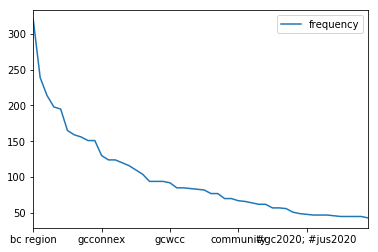

In [45]:
%matplotlib inline

tag_freq.head(50).plot()

In [46]:
tag_freq.to_csv(os.path.join(output_path, 'blog_tags.csv'))

In [47]:
from collections import OrderedDict

In [48]:
# Create a sorted dictionary based on the frequency

sorted_tag_freq = OrderedDict(sorted(tag_frequency.items(),
                                key=lambda kv: kv[1],
                                reverse=True))

In [49]:
sorted_tag_freq

OrderedDict([('bc region', 319),
             ('leadership', 239),
             ('aandc', 214),
             ('aandc bc region', 198),
             ('announcement', 195),
             ('engagement', 165),
             ('inac', 159),
             ('innovation', 156),
             ('learning', 151),
             ('inac bc region', 151),
             ('gcconnex', 130),
             ('management', 124),
             ('blueprint 2020', 124),
             ('project management', 120),
             ('clicks and tips', 116),
             ('collaboration', 110),
             ('open source', 104),
             ('social media', 94),
             ('cfia', 94),
             ('nmc', 94),
             ('gcwcc', 92),
             ('communications', 85),
             ('consultation', 85),
             ('change', 84),
             ('expression of interest', 83),
             ('acia', 82),
             ('change management', 77),
             ('manager', 77),
             ('cool tech tip', 70),
           

In [50]:
blogs[7]

(344,
 'CBSA Second Life Pilot Project',
 "I am currently leading a pilot project to trial Second Life as a training tool to support recruit training at Canada Border Services Agency.  I've partnered with some colleagues at Loyalist College to use a virtual border created by Loyalist to support CBSA training.  Loyalist College has been using their virtual border for almost 2 years to support learners in the Customs Law Enforcement Diploma Program.  They've used it with over 50 students and have reported tremendous success.  After meeting Ken Hudson from Loyalist at a conference last year, we agreed to a pilot project to see if the tool would work in CBSA.  We will be trying the virtual border in SL with 250 of our recruits over the coming two months.  We hope to see if the technology is accessible, what technical issues present themselves, and importantly, to see what effect it has on our learners in terms of performance and learning.  \r\n\r\nI'll be presenting our preliminary finding

In [52]:
from bs4 import BeautifulSoup
blog_info = []

for blog in blogs:
    guid, name, description = blog
    name = BeautifulSoup(name, "lxml")
    description = BeautifulSoup(description, "lxml")
    tags = final_tags.get(guid, "None")
    blog_info.append([name.text, description.text, tags])

/home/toferc/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.forbes.com/sites/chicceo/2015/06/04/the-game-of-ethics/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/toferc/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.dea.gov/media/chasing-dragon.shtml" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


### Latent Dirichlet Allocation (LDA)

In [54]:
import logging
import gensim
import bz2
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [55]:
from gensim.utils import simple_preprocess, lemmatize
from gensim.parsing.preprocessing import STOPWORDS as STOPWORDS

from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize

tokenizer = RegexpTokenizer(r'\w+')

In [57]:
# Other method for stopwords - not using here.

from nltk.corpus import stopwords
import nltk

# create English stop word list
en_stops = set(stopwords.words('english'))
fr_stops = set(stopwords.words('french'))

public_service_stops = '''public service canada work http 
https travail gcconnex url'''.split()

In [58]:
public_service_stops

['public',
 'service',
 'canada',
 'work',
 'http',
 'https',
 'travail',
 'gcconnex',
 'url']

In [59]:
def tokenize(text):
    return [token for token in gensim.utils.simple_preprocess(text)
            if token not in STOPWORDS if token not in fr_stops
           if token not in public_service_stops if len(token) > 3]

In [60]:
print(tokenize(blogs[1][2]))

['thanks', 'diligent', 'colleagues', 'pwgsc', 'plan', 'starting', 'come', 'ready', 'users', 'elgg', 'joomla', 'sites', 'following', 'provisos', 'changes', 'profile', 'information', 'elgg', 'lost', 'complete', 'write', 'integration', 'profile', 'fields', 'directory', 'including', 'photo', 'lucky', 'directory', 'integration', 'complete', 'joomla', 'profile', 'info', 'sync', 'elgg', 'effort', 'profile', 'info', 'come', 'directory', 'significant', 'afford', 'time', 'joomla', 'extremely', 'contender']


In [ ]:
#meaningful_words = [w for w in tokens if not w in en_stop if not w in fr_stop]

In [ ]:
#print(meaningful_words)

In [61]:
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [62]:
# Didn't end up going with this.

texts = [p_stemmer.stem(i) for i in meaningful_words]
print(texts)

NameError: name 'meaningful_words' is not defined

In [65]:
# Set up loop to do this for all blogs
from bs4 import BeautifulSoup

texts = []

def blog_to_words(raw_blog):
    clean_blog = BeautifulSoup(raw_blog[2], "lxml")
    #prep_blog = clean_blog.get_text().lower()
    #tokens = tokenizer.tokenize(prep_blog)
    #meaningful_words = [w for w in tokens if not w in en_stops 
                        #if not w in fr_stops]
    #text = [p_stemmer.stem(i) for i in meaningful_words]
    texts.append(tokenize(clean_blog.get_text()))

In [66]:
for i, raw_blog in enumerate(blogs):
    blog_to_words(raw_blog)
    if (i+1)%500 == 0:
        print("Converted {} of {} blogs.".format(i+1, len(blogs)))
    
print("Done!")

Converted 500 of 11530 blogs.
Converted 1000 of 11530 blogs.
Converted 1500 of 11530 blogs.
Converted 2000 of 11530 blogs.
Converted 2500 of 11530 blogs.
Converted 3000 of 11530 blogs.
Converted 3500 of 11530 blogs.
Converted 4000 of 11530 blogs.
Converted 4500 of 11530 blogs.
Converted 5000 of 11530 blogs.
Converted 5500 of 11530 blogs.
Converted 6000 of 11530 blogs.
Converted 6500 of 11530 blogs.
Converted 7000 of 11530 blogs.
Converted 7500 of 11530 blogs.
Converted 8000 of 11530 blogs.
Converted 8500 of 11530 blogs.
Converted 9000 of 11530 blogs.


/home/toferc/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.dea.gov/media/chasing-dragon.shtml" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Converted 9500 of 11530 blogs.
Converted 10000 of 11530 blogs.
Converted 10500 of 11530 blogs.
Converted 11000 of 11530 blogs.
Converted 11500 of 11530 blogs.
Done!


In [67]:
# Went to bed here
texts[9422]

['gold',
 'rush',
 'winner',
 'elizabeth',
 'macdougall',
 'charity',
 'family',
 'place',
 'east',
 'prince',
 'community',
 'coalition',
 'reminder',
 'signing',
 'number',
 'clipboard',
 'book',
 'book']

In [68]:
from gensim import corpora, models

dictionary = corpora.Dictionary(texts) # could include prune_at=2000

2017-03-09 13:30:58,760 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-03-09 13:31:00,624 : INFO : adding document #10000 to Dictionary(60508 unique tokens: ['blog', 'entry', 'gcpedia', 'geds', 'social']...)
2017-03-09 13:31:00,931 : INFO : built Dictionary(64856 unique tokens: ['blog', 'entry', 'gcpedia', 'geds', 'social']...) from 11530 documents (total 1903580 corpus positions)


In [69]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [70]:
dictionary.save('gcconnex_blogs_dictionary_data')

2017-03-09 13:31:07,353 : INFO : saving Dictionary object under gcconnex_blogs_dictionary_data, separately None
2017-03-09 13:31:07,387 : INFO : saved gcconnex_blogs_dictionary_data


In [71]:
# Generate the LDA model for our blog corpus

ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=30,
                                           id2word = dictionary,
                                            chunksize=1000,
                                            passes=1)


2017-03-09 13:31:09,272 : INFO : using symmetric alpha at 0.03333333333333333
2017-03-09 13:31:09,274 : INFO : using symmetric eta at 1.5418773899099542e-05
2017-03-09 13:31:09,286 : INFO : using serial LDA version on this node
2017-03-09 13:31:30,927 : INFO : running online LDA training, 30 topics, 1 passes over the supplied corpus of 11530 documents, updating every 3000 documents, evaluating every ~11530 documents, iterating 50x with a convergence threshold of 0.001000
2017-03-09 13:31:30,928 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2017-03-09 13:31:30,934 : INFO : training LDA model using 3 processes
2017-03-09 13:31:31,656 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1000/11530, outstanding queue size 1
2017-03-09 13:31:32,518 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #2000/11530, outstanding queue size 2
2017-03-09 13:31:32,535 : INFO : PROGRESS: 

In [72]:
ldamodel.print_topics(num_topics=20, num_words=6)

2017-03-09 13:32:06,117 : INFO : topic #9 (0.033): 0.004*"information" + 0.004*"employees" + 0.004*"people" + 0.003*"like" + 0.003*"management" + 0.003*"time"
2017-03-09 13:32:06,124 : INFO : topic #21 (0.033): 0.006*"information" + 0.004*"government" + 0.003*"services" + 0.003*"people" + 0.003*"management" + 0.003*"open"
2017-03-09 13:32:06,128 : INFO : topic #19 (0.033): 0.005*"information" + 0.004*"time" + 0.004*"managers" + 0.004*"management" + 0.004*"team" + 0.003*"services"
2017-03-09 13:32:06,133 : INFO : topic #22 (0.033): 0.006*"information" + 0.005*"women" + 0.003*"government" + 0.003*"plus" + 0.003*"data" + 0.002*"employees"
2017-03-09 13:32:06,137 : INFO : topic #11 (0.033): 0.004*"project" + 0.004*"information" + 0.003*"need" + 0.003*"open" + 0.003*"tools" + 0.003*"software"
2017-03-09 13:32:06,142 : INFO : topic #0 (0.033): 0.004*"women" + 0.003*"services" + 0.003*"year" + 0.003*"plus" + 0.003*"like" + 0.002*"open"
2017-03-09 13:32:06,148 : INFO : topic #18 (0.033): 0.007

[(9,
  '0.004*"information" + 0.004*"employees" + 0.004*"people" + 0.003*"like" + 0.003*"management" + 0.003*"time"'),
 (21,
  '0.006*"information" + 0.004*"government" + 0.003*"services" + 0.003*"people" + 0.003*"management" + 0.003*"open"'),
 (19,
  '0.005*"information" + 0.004*"time" + 0.004*"managers" + 0.004*"management" + 0.004*"team" + 0.003*"services"'),
 (22,
  '0.006*"information" + 0.005*"women" + 0.003*"government" + 0.003*"plus" + 0.003*"data" + 0.002*"employees"'),
 (11,
  '0.004*"project" + 0.004*"information" + 0.003*"need" + 0.003*"open" + 0.003*"tools" + 0.003*"software"'),
 (0,
  '0.004*"women" + 0.003*"services" + 0.003*"year" + 0.003*"plus" + 0.003*"like" + 0.002*"open"'),
 (18,
  '0.007*"group" + 0.004*"like" + 0.003*"time" + 0.003*"team" + 0.003*"need" + 0.003*"people"'),
 (26,
  '0.004*"team" + 0.003*"plus" + 0.003*"être" + 0.003*"people" + 0.003*"time" + 0.002*"like"'),
 (12,
  '0.006*"open" + 0.005*"government" + 0.004*"information" + 0.004*"employees" + 0.003

In [ ]:
# Consider trying Kaggle.com word2vec tutorial

In [82]:
ldamodel.top_topics(corpus, num_words=16)

[([(0.0098336755171503643, 'plus'),
   (0.0030773426498965193, 'comme'),
   (0.0027897338526045646, 'faire'),
   (0.0027430597107063848, 'information'),
   (0.0025734042081591996, 'cette'),
   (0.0024936474686610499, 'temps'),
   (0.0024171581258334608, 'innovation'),
   (0.002316028467809299, 'time'),
   (0.0022785121545425661, 'employés'),
   (0.0021675310343307547, 'questions'),
   (0.002160409324074145, 'fonction'),
   (0.0021512061862643088, 'services'),
   (0.0021308101465265499, 'être'),
   (0.0019939671370842725, 'publique'),
   (0.0019899404771725089, 'tout'),
   (0.0019741896210939318, 'tous')],
  -138.12952205621568),
 ([(0.0063380312268983569, 'people'),
   (0.0048817658175111332, 'time'),
   (0.0039886989575119054, 'like'),
   (0.0034058215995086236, 'life'),
   (0.0033811012309898831, 'know'),
   (0.0032825245829532592, 'want'),
   (0.003063549656237583, 'things'),
   (0.0027573297307261885, 'information'),
   (0.0027375961562634932, 'good'),
   (0.0025543156478495619, 'c

In [74]:
from pprint import pprint

In [75]:
from collections import defaultdict, OrderedDict

In [76]:
frequency = defaultdict(int)

In [77]:
# Remove words that occur less than 5 times and than have less than 3 letters

texts = [[token for token in text if frequency[token] > 5 if len(token) > 3]
         for text in texts]

In [78]:
# Count the frequency of each token from our text

for text in texts:
    for token in text:
        frequency[token] += 1

In [79]:
# Create a sorted dictionary based on the frequency

sorted_freq = OrderedDict(sorted(frequency.items(),
                                key=lambda kv: kv[1],
                                reverse=True))

In [80]:
sorted_freq

OrderedDict([('blog', 0),
             ('entry', 0),
             ('gcpedia', 0),
             ('geds', 0),
             ('social', 0),
             ('networking', 0),
             ('site', 0),
             ('working', 0),
             ('diligently', 0),
             ('getting', 0),
             ('running', 0),
             ('hope', 0),
             ('ready', 0),
             ('release', 0),
             ('group', 0),
             ('december', 0),
             ('thanks', 0),
             ('diligent', 0),
             ('colleagues', 0),
             ('pwgsc', 0),
             ('plan', 0),
             ('starting', 0),
             ('come', 0),
             ('users', 0),
             ('elgg', 0),
             ('joomla', 0),
             ('sites', 0),
             ('following', 0),
             ('provisos', 0),
             ('changes', 0),
             ('profile', 0),
             ('information', 0),
             ('lost', 0),
             ('complete', 0),
             ('write', 0),
      

In [83]:
tfidf_model = models.tfidfmodel.TfidfModel(
    corpus)

2017-03-09 13:44:14,098 : INFO : collecting document frequencies
2017-03-09 13:44:14,101 : INFO : PROGRESS: processing document #0
2017-03-09 13:44:14,402 : INFO : PROGRESS: processing document #10000
2017-03-09 13:44:14,457 : INFO : calculating IDF weights for 11530 documents and 64855 features (1286845 matrix non-zeros)


In [85]:
with open('blogs.csv', 'w+', encoding='latin-1') as f:
    for blog in blogs:
        f.write(str(blog))


In [87]:
# Prep for NLTK analysis

full_text = "\n".join(str(blogs))


tokens = word_tokenize(full_text)
text = nltk.Text(tokens)
sens = nltk.sent_tokenize(raw)

LookupError: 
**********************************************************************
  Resource 'tokenizers/punkt/PY3/english.pickle' not found.
  Please use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/home/toferc/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************

In [ ]:
freq_long(text)

In [ ]:
pos_trigrams(text)